# Setup

In [2]:
%cd ../

/Volumes/XUANTHANH/DataScience-RealEstateTrendAnalysis/MachineLearningModels


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from scipy import stats
from prophet import Prophet
import os
import logging
import warnings
import joblib

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from math import sqrt

from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import STL
from prophet import Prophet
import xgboost as xgb

data_dir = 'data/final_2nd.csv'
raw_df = pd.read_csv(data_dir)

# Preprocessing

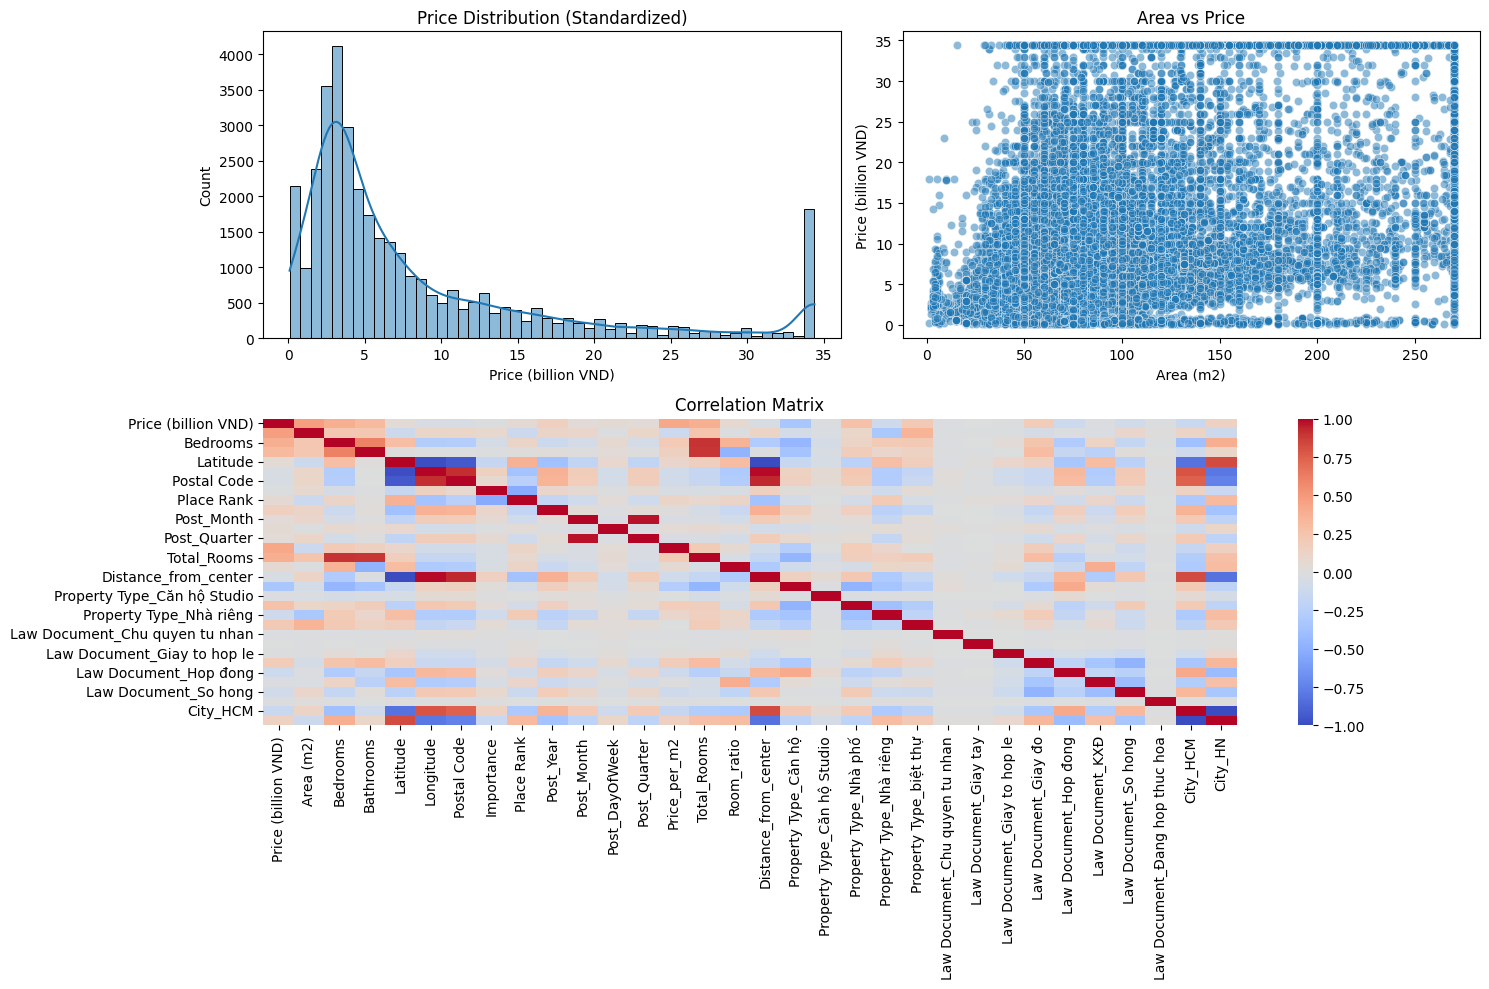

{'total_records': 36062, 'missing_values': {'ID': 0, 'Price (billion VND)': 0, 'Area (m2)': 0, 'Bedrooms': 0, 'Bathrooms': 0, 'Address': 0, 'Post Date': 0, 'Latitude': 0, 'Longitude': 0, 'Postal Code': 0, 'Importance': 0, 'Place Rank': 0, 'Post_Year': 0, 'Post_Month': 0, 'Post_DayOfWeek': 0, 'Post_Quarter': 0, 'Price (billion VND)_outlier': 0, 'Area (m2)_outlier': 0, 'Bedrooms_outlier': 0, 'Bathrooms_outlier': 0, 'Price_per_m2': 0, 'Total_Rooms': 0, 'Room_ratio': 0, 'Distance_from_center': 0, 'District': 0, 'Property Type_Căn hộ': 0, 'Property Type_Căn hộ Studio': 0, 'Property Type_Nhà phố': 0, 'Property Type_Nhà riêng': 0, 'Property Type_biệt thự': 0, 'Law Document_Chu quyen tu nhan': 0, 'Law Document_Giay tay': 0, 'Law Document_Giay to hop le': 0, 'Law Document_Giay đo': 0, 'Law Document_Hop đong': 0, 'Law Document_KXĐ': 0, 'Law Document_So hong': 0, 'Law Document_Đang hop thuc hoa': 0, 'City_HCM': 0, 'City_HN': 0}, 'numeric_stats': {'Price (billion VND)': {'count': 36062.0, 'mean': 

In [4]:
def data_preprocessing(df):
    df_clean = df.copy()

    # 1. Basic Cleaning and Data Type Adjustments
    # Remove unnecessary columns if present
    if 'Unnamed: 0' in df_clean.columns:
        df_clean = df_clean.drop('Unnamed: 0', axis=1)

    # Convert discrete numerical columns to integer
    integer_columns = ['Bedrooms', 'Bathrooms', 'Place Rank', 'Postal Code']
    for col in integer_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce', downcast='integer')

    # Remove rows with invalid numeric conversions
    df_clean = df_clean.dropna(subset=integer_columns, how='any')

    # Convert Bedrooms and Bathrooms to int
    df_clean['Bedrooms'] = df_clean['Bedrooms'].astype(int)
    df_clean['Bathrooms'] = df_clean['Bathrooms'].astype(int)

    # Ensure numeric columns used later are numeric
    numeric_cols = ['Price (billion VND)', 'Area (m2)', 'Bedrooms', 'Bathrooms']
    for col in numeric_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # Remove rows with missing essential numeric values
    df_clean = df_clean.dropna(subset=numeric_cols, how='any')

    # Remove negative or zero values from numeric features where not logical
    for col in numeric_cols:
        df_clean = df_clean[df_clean[col] > 0]

    # 2. Geographic Coordinate Filtering (Vietnam bounds approx)
    if 'Latitude' in df_clean.columns and 'Longitude' in df_clean.columns:
        df_clean = df_clean[
            (df_clean['Latitude'] >= 8.0) & (df_clean['Latitude'] <= 24.0) &
            (df_clean['Longitude'] >= 102.0) & (df_clean['Longitude'] <= 110.0)
        ]

    # 3. Date Processing
    if 'Post Date' in df_clean.columns:
        df_clean['Post Date'] = pd.to_datetime(df_clean['Post Date'], errors='coerce')
        df_clean['Post_Year'] = df_clean['Post Date'].dt.year
        df_clean['Post_Month'] = df_clean['Post Date'].dt.month
        df_clean['Post_DayOfWeek'] = df_clean['Post Date'].dt.dayofweek
        df_clean['Post_Quarter'] = df_clean['Post Date'].dt.quarter

    # 4. Outlier Treatment for Numeric Columns using IQR
    def handle_outliers(df, column):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        # Mark outliers
        df[f'{column}_outlier'] = ~df[column].between(lower_bound, upper_bound)
        # Clip values to the boundaries
        df[column] = df[column].clip(lower_bound, upper_bound)
        return df

    for col in numeric_cols:
        df_clean = handle_outliers(df_clean, col)

    # 5. Feature Engineering
    # Price per square meter
    df_clean['Price_per_m2'] = df_clean['Price (billion VND)'] / df_clean['Area (m2)']

    # Total and ratio of rooms
    df_clean['Total_Rooms'] = df_clean['Bedrooms'] + df_clean['Bathrooms']
    df_clean['Room_ratio'] = df_clean['Bedrooms'] / df_clean['Bathrooms'].replace(0, np.nan)

    # Distance from center (approx. center using mean coords)
    if 'Latitude' in df_clean.columns and 'Longitude' in df_clean.columns:
        mean_lat, mean_lon = df_clean['Latitude'].mean(), df_clean['Longitude'].mean()
        df_clean['Distance_from_center'] = np.sqrt((df_clean['Latitude'] - mean_lat)**2 + (df_clean['Longitude'] - mean_lon)**2)

    # Extract district info from Address if available
    if 'Address' in df_clean.columns:
        df_clean['District'] = df_clean['Address'].apply(lambda x: x.split(',')[1].strip() if isinstance(x, str) and len(x.split(',')) > 1 else 'Unknown')

    # 6. Categorical Encoding: One-Hot Encoding
    categorical_features = []
    for cat_feat in ['Property Type', 'Law Document', 'City']:
        if cat_feat in df_clean.columns:
            categorical_features.append(cat_feat)

    # Apply OneHotEncoder if we have categorical features
    if categorical_features:
        onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_data = onehot.fit_transform(df_clean[categorical_features])
        encoded_col_names = []
        # Generate column names for encoded features
        for i, cat_feat in enumerate(categorical_features):
            encoded_col_names.extend([f"{cat_feat}_{cat}" for cat in onehot.categories_[i]])

        encoded_df = pd.DataFrame(encoded_data, columns=encoded_col_names, index=df_clean.index)
        df_clean = pd.concat([df_clean, encoded_df], axis=1)
        df_clean = df_clean.drop(columns=categorical_features, errors='ignore')

    return df_clean

def analyze_dataset(df_clean):
    """Generate basic analysis of the cleaned dataset."""
    analysis = {
        'total_records': len(df_clean),
        'missing_values': df_clean.isnull().sum().to_dict(),
        'numeric_stats': df_clean.describe(include=[np.number]).to_dict(),
        'object_stats': {col: df_clean[col].value_counts().to_dict() for col in df_clean.select_dtypes(include='object')},
    }
    return analysis

def plot_insights(df_clean):
    """Plot some key insights from the preprocessed data."""
    plt.figure(figsize=(15, 10))

    # Price distribution
    plt.subplot(2, 2, 1)
    sns.histplot(data=df_clean, x='Price (billion VND)', bins=50, kde=True)
    plt.title('Price Distribution (Standardized)')

    # Area vs Price scatter plot
    if 'Area (m2)' in df_clean.columns:
        plt.subplot(2, 2, 2)
        sns.scatterplot(data=df_clean, x='Area (m2)', y='Price (billion VND)', alpha=0.5)
        plt.title('Area vs Price')

    # Correlation heatmap
    plt.subplot(2, 2, (3, 4))
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    corr_matrix = df_clean[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')

    plt.tight_layout()
    plt.show()

def cleaner(df):
    # Preprocess the data
    df_clean = data_preprocessing(df)

    # Analyze the dataset
    analysis = analyze_dataset(df_clean)

    # Plot insights
    plot_insights(df_clean)

    return df_clean, analysis

df, analysis_results = cleaner(raw_df)
df.to_csv('data/data_updated.csv')
print(analysis_results)

# Price Prediction

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For modeling
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# For model saving
import joblib

# For UI
import ipywidgets as widgets
from IPython.display import display, clear_output

# For model interpretation
import shap

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ===========================
# 1. Data Loading and Initial Processing
# ===========================

# Load the dataset
df = pd.read_csv('data/data_updated.csv', parse_dates=['Post Date'])

# Display initial information
print("Dataset Loaded Successfully!")
print(f"Shape: {df.shape}")
print("Columns:")
print(df.columns.tolist())

# Drop 'ID' and 'Address' as they are not useful for prediction
df.drop(['ID', 'Address'], axis=1, inplace=True)

# ===========================
# 2. Feature Engineering
# ===========================

# Extract Season from Post_Month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Post_Month'].apply(get_season)

# Create interaction features
df['Price_per_bedroom'] = df['Price (billion VND)'] / df['Bedrooms']
df['bath_bed_ratio'] = df['Bathrooms'] / df['Bedrooms']

# Encode boolean flags as integers
bool_cols = ['Price (billion VND)_outlier', 'Area (m2)_outlier',
             'Bedrooms_outlier', 'Bathrooms_outlier']
df[bool_cols] = df[bool_cols].astype(int)

# Drop 'Post Date' as individual components are already extracted
df.drop('Post Date', axis=1, inplace=True)

# ===========================
# 3. Feature Selection
# ===========================

# Define target and features
X = df.drop('Price (billion VND)', axis=1)
y = df['Price (billion VND)']

# Identify categorical and numerical features
categorical_features = ['District', 'Season']
# Assuming 'Property Type_*' and 'Law Document_*' are already one-hot encoded (0/1)
# and 'City_HCM', 'City_HN' are binary indicators
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove target variable if present
numerical_features = [col for col in numerical_features if col != 'Price (billion VND)']

# ===========================
# 4. Data Splitting
# ===========================

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print("\nData Split:")
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

# ===========================
# 5. Preprocessing Pipelines
# ===========================

# Numerical features: Scaling
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical features: One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# ===========================
# 6. Model Pipelines
# ===========================

# 1. Linear Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 2. Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# 3. XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# 4. LightGBM
lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(random_state=42))
])

# 5. CatBoost
catboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(verbose=0, random_state=42))
])

# ===========================
# 7. Model Training and Evaluation
# ===========================

# Function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%\n")

# Train and evaluate Linear Regression
print("Training Linear Regression...")
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
evaluate_model(y_test, y_pred_lr, "Linear Regression")

# Train and evaluate Random Forest
print("Training Random Forest...")
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
evaluate_model(y_test, y_pred_rf, "Random Forest")

# Train and evaluate XGBoost
print("Training XGBoost...")
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
evaluate_model(y_test, y_pred_xgb, "XGBoost")

# Train and evaluate LightGBM
print("Training LightGBM...")
lgb_pipeline.fit(X_train, y_train)
y_pred_lgb = lgb_pipeline.predict(X_test)
evaluate_model(y_test, y_pred_lgb, "LightGBM")

# Train and evaluate CatBoost
print("Training CatBoost...")
catboost_pipeline.fit(X_train, y_train)
y_pred_cat = catboost_pipeline.predict(X_test)
evaluate_model(y_test, y_pred_cat, "CatBoost")

# ===========================
# 8. Performance Comparison
# ===========================

# Compare model performances
model_performances = {
    'Linear Regression': {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        'MAE': mean_absolute_error(y_test, y_pred_lr),
        'R2': r2_score(y_test, y_pred_lr)
    },
    'Random Forest': {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        'MAE': mean_absolute_error(y_test, y_pred_rf),
        'R2': r2_score(y_test, y_pred_rf)
    },
    'XGBoost': {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
        'MAE': mean_absolute_error(y_test, y_pred_xgb),
        'R2': r2_score(y_test, y_pred_xgb)
    },
    'LightGBM': {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lgb)),
        'MAE': mean_absolute_error(y_test, y_pred_lgb),
        'R2': r2_score(y_test, y_pred_lgb)
    },
    'CatBoost': {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_cat)),
        'MAE': mean_absolute_error(y_test, y_pred_cat),
        'R2': r2_score(y_test, y_pred_cat)
    }
}

performance_df = pd.DataFrame(model_performances).T
print("Model Performance Comparison:")
display(performance_df)

# Identify the best model based on RMSE (you can choose other metrics as well)
best_model_name = performance_df['RMSE'].idxmin()
print(f"\nBest Model Based on RMSE: {best_model_name}")

# ===========================
# 9. Hyperparameter Tuning for the Best Model
# ===========================

# Assuming LightGBM performed the best
if best_model_name == 'LightGBM':
    best_pipeline = lgb_pipeline
elif best_model_name == 'XGBoost':
    best_pipeline = xgb_pipeline
elif best_model_name == 'Random Forest':
    best_pipeline = rf_pipeline
elif best_model_name == 'CatBoost':
    best_pipeline = catboost_pipeline
else:
    best_pipeline = lr_pipeline

# Define parameter grid for LightGBM (adjust if another model is best)
if best_model_name == 'LightGBM':
    param_grid = {
        'regressor__num_leaves': [31, 50, 70],
        'regressor__n_estimators': [100, 500, 1000],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [-1, 10, 20]
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'regressor__n_estimators': [100, 500, 1000],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 6, 10],
        'regressor__subsample': [0.6, 0.8, 1.0]
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'regressor__n_estimators': [100, 500],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'CatBoost':
    param_grid = {
        'regressor__iterations': [500, 1000],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__depth': [6, 10, 12]
    }
else:
    param_grid = {
        'regressor__fit_intercept': [True, False],
        'regressor__normalize': [True, False]
    }

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=best_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
print(f"\nStarting GridSearchCV for {best_model_name}...")
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"\nBest Parameters for {best_model_name}: {grid_search.best_params_}")
print(f"Best CV RMSE: {-grid_search.best_score_:.4f}")

# Update the pipeline with best parameters
best_pipeline = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_best = best_pipeline.predict(X_test)
evaluate_model(y_test, y_pred_best, f"Tuned {best_model_name}")

# ===========================
# 10. Residual Analysis
# ===========================

# Residual Analysis for Tuned Model
residuals = y_test - y_pred_best

plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True, bins=50)
plt.title(f'Residuals Distribution - Tuned {best_model_name}')
plt.xlabel('Residuals')
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred_best, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residuals vs. Predicted Values - Tuned {best_model_name}')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# ===========================
# 11. Feature Importance
# ===========================

# Feature Importance from Tuned Model (only for tree-based models)
if best_model_name in ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']:
    importances = best_pipeline.named_steps['regressor'].feature_importances_
    # Get feature names after preprocessing
    preprocessor.fit(X_train)
    numerical_cols = numerical_features
    categorical_cols = best_pipeline.named_steps['preprocessor'].transformers_[1][2]
    encoded_cat_features = best_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
    feature_names = numerical_cols + list(encoded_cat_features)

    feat_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feat_importances.head(20))
    plt.title(f'Top 20 Feature Importances - Tuned {best_model_name}')
    plt.tight_layout()
    plt.show()
else:
    print("Feature importance is not available for this model.")

# ===========================
# 12. Cross-Validation
# ===========================

# Cross-Validation for Tuned Model
cv_scores = cross_val_score(best_pipeline, X, y, cv=5,
                            scoring='neg_root_mean_squared_error', n_jobs=-1)
print(f"\nCross-Validation RMSE Scores: {-cv_scores}")
print(f"Mean CV RMSE: {-cv_scores.mean():.4f}")
print(f"Std CV RMSE: {cv_scores.std():.4f}")

# ===========================
# 13. Model Saving
# ===========================

# Save the best model
model_filename = f'best_{best_model_name.lower()}_model.pkl'
joblib.dump(best_pipeline, model_filename)
print(f"\nBest {best_model_name} model saved as '{model_filename}'.")

# ===========================
# 14. Simple User Interface for Inference
# ===========================

# Define input widgets for features
# Note: Adjust the widgets based on the features used in the model
# For simplicity, we'll create widgets for numerical_features and categorical_features

# Function to create input widgets
def create_input_widgets(numerical_features, categorical_features, encoded_cat_features):
    input_widgets = {}

    # Numerical Features
    for feature in numerical_features:
        if feature in ['Price_per_bedroom', 'bath_bed_ratio']:
            # These are interaction features; they should be calculated from Bedrooms and Bathrooms
            continue
        widget = widgets.FloatText(
            value=0.0,
            description=feature,
            disabled=False
        )
        input_widgets[feature] = widget

    # Categorical Features
    for feature in categorical_features:
        if feature == 'District':
            # Get unique districts from the dataset
            districts = df['District'].unique().tolist()
            widget = widgets.Dropdown(
                options=districts,
                value=districts[0],
                description=feature,
                disabled=False,
            )
        elif feature == 'Season':
            seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
            widget = widgets.Dropdown(
                options=seasons,
                value='Winter',
                description=feature,
                disabled=False,
            )
        input_widgets[feature] = widget

    return input_widgets

# Get feature names after one-hot encoding
preprocessor.fit(X_train)
encoded_cat_features = best_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)

# Create input widgets
input_widgets = create_input_widgets(numerical_features, categorical_features, encoded_cat_features)

# Display the widgets
input_box = widgets.VBox([widget for widget in input_widgets.values()])
display(input_box)

# Create a button for prediction
predict_button = widgets.Button(
    description='Predict Price',
    button_style='success',
    tooltip='Click to predict the property price',
    icon='check'
)
display(predict_button)

# Output widget to display prediction
output = widgets.Output()
display(output)

# Define the prediction function
def on_predict_button_clicked(b):
    with output:
        clear_output()
        # Collect input data
        input_data = {}
        for feature, widget in input_widgets.items():
            input_data[feature] = widget.value

        # Create DataFrame
        input_df = pd.DataFrame([input_data])

        # Feature Engineering for input
        # Extract Season (already handled by widget)
        # Interaction features
        if 'Bedrooms' in input_df.columns and 'Bathrooms' in input_df.columns:
            input_df['Price_per_bedroom'] = input_df['Price_per_bedroom'] if 'Price_per_bedroom' in input_df.columns else 0
            input_df['bath_bed_ratio'] = input_df['Bathrooms'] / input_df['Bedrooms']
        else:
            input_df['bath_bed_ratio'] = 0

        # Handle one-hot encoding for categorical features is already managed by the pipeline

        # Predict using the saved model
        prediction = best_pipeline.predict(input_df)[0]
        print(f"Predicted Price (billion VND): {prediction:.2f}")

# Attach the prediction function to the button
predict_button.on_click(on_predict_button_clicked)

# ===========================
# 15. Model Interpretation with SHAP (Optional)
# ===========================

import shap

# Initialize SHAP explainer
explainer = shap.Explainer(best_pipeline.named_steps['regressor'],
                           best_pipeline.named_steps['preprocessor'].transform(X_test))
# Compute SHAP values
shap_values = explainer(best_pipeline.named_steps['preprocessor'].transform(X_test))

# Summary plot
shap.summary_plot(shap_values, features=best_pipeline.named_steps['preprocessor'].transform(X_test), feature_names=feature_names, show=False)
plt.title(f'SHAP Summary Plot - Tuned {best_model_name}')
plt.show()

Dataset Loaded Successfully!
Shape: (36062, 41)
Columns:
['Unnamed: 0', 'ID', 'Price (billion VND)', 'Area (m2)', 'Bedrooms', 'Bathrooms', 'Address', 'Post Date', 'Latitude', 'Longitude', 'Postal Code', 'Importance', 'Place Rank', 'Post_Year', 'Post_Month', 'Post_DayOfWeek', 'Post_Quarter', 'Price (billion VND)_outlier', 'Area (m2)_outlier', 'Bedrooms_outlier', 'Bathrooms_outlier', 'Price_per_m2', 'Total_Rooms', 'Room_ratio', 'Distance_from_center', 'District', 'Property Type_Căn hộ', 'Property Type_Căn hộ Studio', 'Property Type_Nhà phố', 'Property Type_Nhà riêng', 'Property Type_biệt thự', 'Law Document_Chu quyen tu nhan', 'Law Document_Giay tay', 'Law Document_Giay to hop le', 'Law Document_Giay đo', 'Law Document_Hop đong', 'Law Document_KXĐ', 'Law Document_So hong', 'Law Document_Đang hop thuc hoa', 'City_HCM', 'City_HN']

Data Split:
Training set: (28849, 40), (28849,)
Testing set: (7213, 40), (7213,)
Training Linear Regression...
--- Linear Regression Performance ---
RMSE: 3.247

,RMSE,MAE,R2
Linear Regression,3.247198,1.953835,0.862583
Random Forest,0.028569,0.005419,0.999989
XGBoost,0.202631,0.084982,0.999465
LightGBM,0.161417,0.067083,0.999660
CatBoost,0.188097,0.093428,0.999539



Best Model Based on RMSE: Random Forest

Starting GridSearchCV for Random Forest...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


KeyboardInterrupt: 

# Time Series Analysis

In [ ]:
df = pd.read_csv('data/data_updated.csv')

In [ ]:
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class TimeSeriesModeling:
    def __init__(self, dataframe, date_col='Post Date', target_col='Price (billion VND)', freq='M', models_dir='saved_models'):
        self.df = dataframe.copy()
        self.date_col = date_col
        self.target_col = target_col
        self.freq = freq
        self.models_dir = models_dir  # Directory to save models
        self.df[self.date_col] = pd.to_datetime(self.df[self.date_col], errors='coerce')
        self.df.dropna(subset=[self.date_col, self.target_col], inplace=True)
        self.df.sort_values(by=self.date_col, inplace=True)

        # Create models directory if it doesn't exist
        if not os.path.exists(self.models_dir):
            os.makedirs(self.models_dir)
        logging.info(f"Models will be saved to '{self.models_dir}' directory.")

    def prepare_time_series_data(self, groupby_cols=None):
        """
        Prepare the main time series data by optional grouping and resampling.
        Apply forward fill interpolation if needed.
        """
        logging.info("Preparing time series data.")
        if groupby_cols:
            time_series = self.df.groupby(
                [pd.Grouper(key=self.date_col, freq=self.freq)] + groupby_cols
            )[self.target_col].mean()
            time_series = time_series.reset_index().set_index(self.date_col)[self.target_col]
        else:
            time_series = self.df.set_index(self.date_col)[self.target_col].resample(self.freq).mean()

        return time_series.interpolate()

    def check_stationarity_and_difference(self, series, alpha=0.05, max_diff=2):
        """
        Check stationarity using Augmented Dickey-Fuller test and difference the series until stationary or max_diff.
        """
        from statsmodels.tsa.stattools import adfuller
        def adf_test(x):
            result = adfuller(x.dropna(), autolag='AIC')
            return result[1]  # p-value

        ts = series.copy()
        diff_order = 0
        while diff_order <= max_diff:
            p_value = adf_test(ts)
            if p_value < alpha:
                # Stationary
                if diff_order > 0:
                    logging.info(f"Series differenced {diff_order} time(s) to achieve stationarity.")
                break
            ts = ts.diff().dropna()
            diff_order += 1

        if diff_order > max_diff:
            logging.warning("Series may still be non-stationary after maximum differencing attempts.")

        return ts, diff_order

    def add_features_for_xgboost(self, series, lags=12, rolling_window=3):
        """
        Create lagged features, seasonal decomposition features, and rolling stats for XGBoost.
        """
        df = pd.DataFrame({'y': series})

        # Lags
        for i in range(1, lags+1):
            df[f'lag_{i}'] = df['y'].shift(i)

        # Rolling features (mean, std)
        df['roll_mean'] = df['y'].shift(1).rolling(rolling_window).mean()
        df['roll_std'] = df['y'].shift(1).rolling(rolling_window).std()

        # Seasonal decomposition using STL
        period = 12 if self.freq == 'M' else 7
        stl = STL(series, period=period, robust=True)
        res = stl.fit()
        df['trend'] = res.trend
        df['seasonal'] = res.seasonal
        df['resid'] = res.resid

        # Time-based features
        df['month'] = df.index.month
        df['quarter'] = df.index.quarter
        df['year'] = df.index.year

        return df.dropna()

    def evaluate_model(self, y_true, y_pred):
        """
        Calculate multiple evaluation metrics.
        """
        return {
            'MSE': mean_squared_error(y_true, y_pred),
            'RMSE': sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100,
            'R2': r2_score(y_true, y_pred)
        }

    def plot_forecast(self, test, forecast, title='Forecast', lower_ci=None, upper_ci=None):
        plt.figure(figsize=(12,6))
        plt.plot(test.index, test.values, label='Actual', color='blue')
        plt.plot(test.index, forecast, label='Forecast', color='red')
        if lower_ci is not None and upper_ci is not None:
            plt.fill_between(test.index, lower_ci, upper_ci, color='pink', alpha=0.3, label='Confidence Interval')
        plt.title(title)
        plt.legend()
        plt.show()

    def save_model(self, model, model_name):
        """
        Save the trained model to the models directory.
        """
        model_path = os.path.join(self.models_dir, f"{model_name}.joblib")
        joblib.dump(model, model_path)
        logging.info(f"Model '{model_name}' saved to '{model_path}'.")

    def load_model(self, model_name):
        """
        Load a saved model from the models directory.
        """
        model_path = os.path.join(self.models_dir, f"{model_name}.joblib")
        if not os.path.exists(model_path):
            logging.error(f"Model '{model_name}' does not exist in '{self.models_dir}'.")
            return None
        model = joblib.load(model_path)
        logging.info(f"Model '{model_name}' loaded from '{model_path}'.")
        return model

    def sarima_model(self, series, seasonal_period=None, boxcox=True, trace=True, error_action='warn', stepwise=True, n_jobs=-1):
        """
        Enhanced SARIMA modeling with automatic parameter selection using auto_arima.
        - seasonal_period: int, the periodicity of the data. If None, inferred from frequency.
        - boxcox: bool, whether to perform Box-Cox transformation.
        - trace: bool, whether to print the progress.
        - error_action: str, action on error.
        - stepwise: bool, whether to use stepwise search to reduce computation.
        - n_jobs: int, number of jobs for parallel processing.
        """
        logging.info("Building SARIMA model.")
        train_size = int(len(series)*0.8)
        train, test = series[:train_size], series[train_size:]

        # Automatically infer seasonal_period if not provided
        if not seasonal_period:
            if self.freq == 'M':
                seasonal_period = 12
            elif self.freq == 'W':
                seasonal_period = 52
            elif self.freq == 'D':
                seasonal_period = 7
            else:
                seasonal_period = 1  # No seasonality
            logging.info(f"Seasonal period inferred as {seasonal_period} based on frequency '{self.freq}'.")

        # Box-Cox transformation to stabilize variance
        if boxcox:
            logging.info("Applying Box-Cox transformation.")
            model = auto_arima(train,
                               seasonal=True,
                               m=seasonal_period,
                               trace=trace,
                               error_action=error_action,
                               suppress_warnings=True,
                               stepwise=stepwise,
                               n_jobs=n_jobs,
                               start_p=0, start_q=0, max_p=3, max_q=3,
                               start_P=0, start_Q=0, max_P=3, max_Q=3,
                               max_d=2, max_D=2,
                               allow_exogenous=False,
                               enforce_stationarity=True,
                               enforce_invertibility=True,
                               method='lbfgs')  # Optimization method
        else:
            model = auto_arima(train,
                               seasonal=True,
                               m=seasonal_period,
                               trace=trace,
                               error_action=error_action,
                               suppress_warnings=True,
                               stepwise=stepwise,
                               n_jobs=n_jobs,
                               start_p=0, start_q=0, max_p=3, max_q=3,
                               start_P=0, start_Q=0, max_P=3, max_Q=3,
                               max_d=2, max_D=2,
                               allow_exogenous=False,
                               enforce_stationarity=True,
                               enforce_invertibility=True,
                               method='lbfgs')  # Optimization method

        model.fit(train)

        # Forecast with confidence intervals
        forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)

        forecast = pd.Series(forecast, index=test.index)
        lower_ci = pd.Series(conf_int[:,0], index=test.index)
        upper_ci = pd.Series(conf_int[:,1], index=test.index)

        # Evaluate model
        metrics = self.evaluate_model(test, forecast)
        logging.info(f"SARIMA Model Metrics: {metrics}")

        # Plot forecast
        self.plot_forecast(test, forecast, title='SARIMA Model Forecast', lower_ci=lower_ci, upper_ci=upper_ci)

        # Save the model
        self.save_model(model, 'sarima_model')

        return {
            'model': model,
            'forecast': forecast,
            'lower_ci': lower_ci,
            'upper_ci': upper_ci,
            'metrics': metrics
        }

    def arima_model(self, series, boxcox=True, trace=True, error_action='warn', stepwise=True, n_jobs=-1):
        """
        Enhanced ARIMA modeling with automatic parameter selection using auto_arima.
        - boxcox: bool, whether to perform Box-Cox transformation.
        - trace: bool, whether to print the progress.
        - error_action: str, action on error.
        - stepwise: bool, whether to use stepwise search to reduce computation.
        - n_jobs: int, number of jobs for parallel processing.
        """
        logging.info("Building ARIMA model.")
        train_size = int(len(series)*0.8)
        train, test = series[:train_size], series[train_size:]

        # Box-Cox transformation to stabilize variance
        if boxcox:
            logging.info("Applying Box-Cox transformation.")
            model = auto_arima(train,
                               seasonal=False,
                               m=1,  # No seasonality
                               trace=trace,
                               error_action=error_action,
                               suppress_warnings=True,
                               stepwise=stepwise,
                               n_jobs=n_jobs,
                               start_p=0, start_q=0, max_p=3, max_q=3,
                               max_d=2,
                               allow_exogenous=False,
                               enforce_stationarity=True,
                               enforce_invertibility=True,
                               method='lbfgs')  # Optimization method
        else:
            model = auto_arima(train,
                               seasonal=False,
                               m=1,  # No seasonality
                               trace=trace,
                               error_action=error_action,
                               suppress_warnings=True,
                               stepwise=stepwise,
                               n_jobs=n_jobs,
                               start_p=0, start_q=0, max_p=3, max_q=3,
                               max_d=2,
                               allow_exogenous=False,
                               enforce_stationarity=True,
                               enforce_invertibility=True,
                               method='lbfgs')  # Optimization method

        model.fit(train)

        # Forecast with confidence intervals
        forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)

        forecast = pd.Series(forecast, index=test.index)
        lower_ci = pd.Series(conf_int[:,0], index=test.index)
        upper_ci = pd.Series(conf_int[:,1], index=test.index)

        # Evaluate model
        metrics = self.evaluate_model(test, forecast)
        logging.info(f"ARIMA Model Metrics: {metrics}")

        # Plot forecast
        self.plot_forecast(test, forecast, title='ARIMA Model Forecast', lower_ci=lower_ci, upper_ci=upper_ci)

        # Save the model
        self.save_model(model, 'arima_model')

        return {
            'model': model,
            'forecast': forecast,
            'lower_ci': lower_ci,
            'upper_ci': upper_ci,
            'metrics': metrics
        }

    def prophet_model(self, series):
        """
        Prophet model for time series forecasting.
        Explores different growth models and seasonalities.
        """
        logging.info("Building Prophet model.")
        train_size = int(len(series)*0.8)
        train, test = series[:train_size], series[train_size:]

        df_prophet = pd.DataFrame({'ds': train.index, 'y': train.values})
        model = Prophet(growth='linear', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)

        # Fit the model and make predictions
        model.fit(df_prophet)
        future = model.make_future_dataframe(periods=len(test), freq=self.freq)
        fcst = model.predict(future)

        # Extract forecast
        forecast = fcst.set_index('ds')['yhat'].iloc[-len(test):]
        lower_ci = fcst.set_index('ds')['yhat_lower'].iloc[-len(test):]
        upper_ci = fcst.set_index('ds')['yhat_upper'].iloc[-len(test):]

        metrics = self.evaluate_model(test, forecast)
        self.plot_forecast(test, forecast, title='Prophet Model Forecast', lower_ci=lower_ci, upper_ci=upper_ci)

        return {
            'model': model,
            'forecast': forecast,
            'lower_ci': lower_ci,
            'upper_ci': upper_ci,
            'metrics': metrics
        }

    def xgboost_model(self, series):
        """
        XGBoost model with lagged features, STL decomposition, and rolling statistics.
        Includes hyperparameter tuning via GridSearchCV and TimeSeriesSplit.
        """
        logging.info("Building XGBoost model.")
        df_features = self.add_features_for_xgboost(series)

        train_size = int(len(df_features)*0.8)
        X = df_features.drop(columns=['y'])
        y = df_features['y']

        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Time series split for cross-validation
        tscv = TimeSeriesSplit(n_splits=3)

        # Detailed hyperparameter grid search
        param_grid = {
            'n_estimators': [100, 200, 300, 500],
            'learning_rate': [0.005, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_child_weight': [1, 3, 5],
            'gamma': [0, 0.1, 0.5]
        }

        xgb_model = xgb.XGBRegressor(random_state=42)
        grid_search = GridSearchCV(xgb_model, param_grid, cv=tscv, scoring='neg_mean_absolute_error', verbose=1)
        grid_search.fit(X_train_scaled, y_train)

        best_model = grid_search.best_estimator_
        forecast = best_model.predict(X_test_scaled)

        metrics = self.evaluate_model(y_test, forecast)
        train_preds = best_model.predict(X_train_scaled)
        residuals = y_train - train_preds
        resid_std = np.std(residuals)
        lower_ci = forecast - 1.96*resid_std
        upper_ci = forecast + 1.96*resid_std

        forecast_series = pd.Series(forecast, index=y_test.index)
        lower_ci_series = pd.Series(lower_ci, index=y_test.index)
        upper_ci_series = pd.Series(upper_ci, index=y_test.index)

        self.plot_forecast(y_test, forecast_series, title='XGBoost Model Forecast',
                           lower_ci=lower_ci_series, upper_ci=upper_ci_series)

        return {
            'model': best_model,
            'forecast': forecast_series,
            'lower_ci': lower_ci_series,
            'upper_ci': upper_ci_series,
            'metrics': metrics
        }

    def compare_models(self):
        """
        Compare multiple time series models on a single dataset.
        """
        # Prepare the raw series
        series = self.prepare_time_series_data()

        # Ensure stationarity
        series_stationary, diff_order = self.check_stationarity_and_difference(series)

        # Run models
        models = {
            'SARIMA': self.sarima_model(series_stationary),
            'ARIMA': self.arima_model(series_stationary),
            'Prophet': self.prophet_model(series_stationary),
            'XGBoost': self.xgboost_model(series_stationary)
        }

        # Comparison
        comparison_df = pd.DataFrame({
            model_name: model['metrics']
            for model_name, model in models.items()
        }).T

        logging.info("Model Comparison:")
        logging.info("\n" + str(comparison_df))

        # Visualize model comparison
        plt.figure(figsize=(10,6))
        comparison_df[['MAE','RMSE','MAPE','R2']].plot(kind='bar', subplots=False)
        plt.title('Model Performance Comparison')
        plt.xlabel('Models')
        plt.ylabel('Metric Value')
        plt.xticks(rotation=0)
        plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        return models, comparison_df

def modeling():
    df = pd.read_csv('dataset/data_updated.csv')

    ts_analyzer = TimeSeriesModeling(df)
    models, comparison = ts_analyzer.compare_models()
    print("\nModel Comparison Metrics:")
    print(comparison)

def load_and_predict(new_data):
    ts_analyzer = TimeSeriesModeling(pd.DataFrame())

    # Load SARIMA model
    sarima = ts_analyzer.load_model('sarima_model')
    if sarima:
        # Example: Forecast using SARIMA
        # forecast = sarima.predict(n_periods=10)
        pass

    # Load ARIMA model
    arima = ts_analyzer.load_model('arima_model')
    if arima:
        # Example: Forecast using ARIMA
        # forecast = arima.predict(n_periods=10)
        pass

    # Load Prophet model
    prophet = ts_analyzer.load_model('prophet_model')
    if prophet:
        # Example: Forecast using Prophet
        future = prophet.make_future_dataframe(periods=10, freq='M')
        fcst = prophet.predict(future)
        forecast = fcst['yhat'].tail(10)
        print("Prophet Forecast:")
        print(forecast)

    # Load XGBoost model and scaler
    xgb_model = ts_analyzer.load_model('xgboost_model')
    if xgb_model:
        scaler = joblib.load(os.path.join(ts_analyzer.models_dir, 'xgboost_scaler.joblib'))
        # Prepare new_data features and scale
        # new_data_scaled = scaler.transform(new_data)
        # forecast = xgb_model.predict(new_data_scaled)
        pass

    # Perform desired operations with loaded models
    pass

modeling()

if __name__ == "__main__":
    new_data = pd.DataFrame()
    load_and_predict(new_data)